In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
import sidetable as stb
warnings.filterwarnings('ignore')

### Import Data

In [4]:
df = pd.read_csv('bank.csv')
pd.options.display.max_columns = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x) #Change Decimal
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Problems
- Customer Churn

# Goals
- What is Credit Score
- What is the correlation of Tenure duration to Salary and Age
- Number of customer who Churn
- From which Country and Gender who did the most Churn
- Find out the usage of having many products
- Advantage of having Credit Cards
- Find out which customer are likely to Churn

# Pengecheckan Dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [7]:
Desc = []

for i in df.columns:
    Desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((((df[i].isna().sum() )/ len(df)) * 100),2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])

pd.DataFrame(data = Desc,
            columns = [
                'Column',
                'DataType',
                'Null',
                'Null (%)',
                'nUnique',
                'Unique Samples'
            ])

,Column,DataType,Null,Null (%),nUnique,Unique Samples
0,RowNumber,int64,0,0.00,10000,"[5304, 5529]"
1,CustomerId,int64,0,0.00,10000,"[15780770, 15814519]"
2,Surname,object,0,0.00,2932,"[Ibeamaka, Peng]"
3,CreditScore,int64,0,0.00,460,"[695, 536]"
4,Geography,object,0,0.00,3,"[France, Germany]"
5,Gender,object,0,0.00,2,"[Male, Female]"
6,Age,int64,0,0.00,70,"[46, 52]"
7,Tenure,int64,0,0.00,11,"[4, 0]"
8,Balance,float64,0,0.00,6382,"[124993.29, 123067.63]"
9,NumOfProducts,int64,0,0.00,4,"[1, 2]"


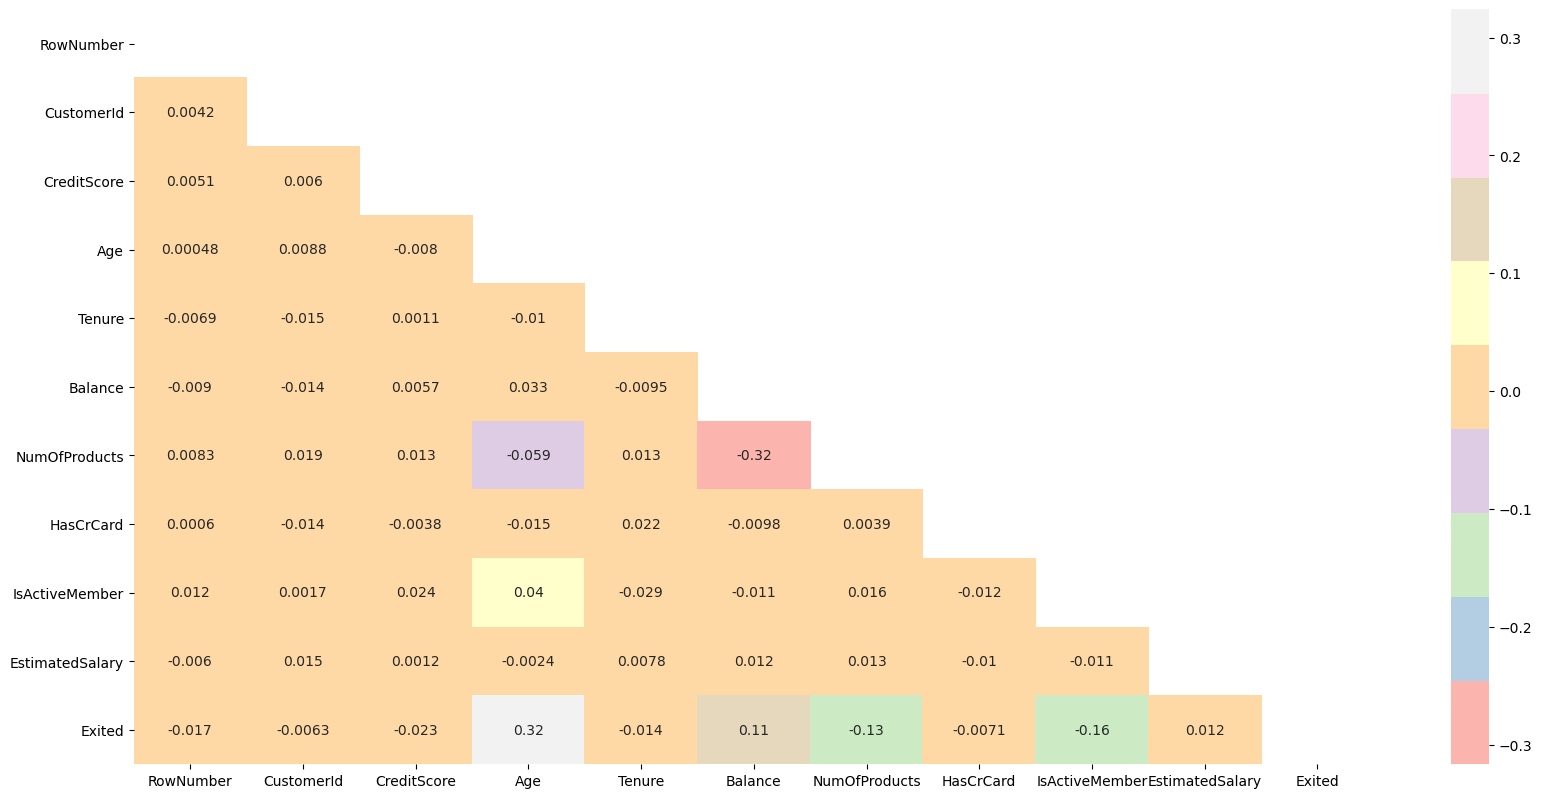

In [8]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df.corr('spearman'), annot=True, cmap = 'Pastel1', mask=mask)
plt.show()

### Outliers

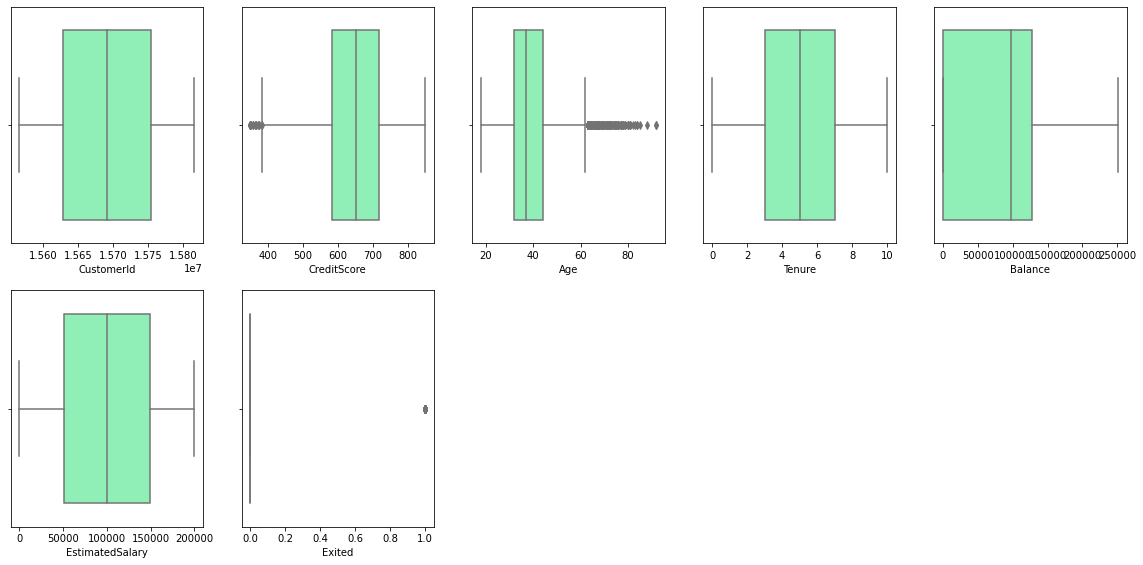

In [18]:
# Outliers by Boxplot
df_describe = df.drop(columns = ['RowNumber','Surname', 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'])

plt.figure(figsize =(20, 20))
x = 1 

for column in df_describe.columns:
    plt.subplot(4,5,x)
    sns.boxplot(x=df_describe[column], palette='rainbow')
    x+=1
plt.tight_layout
plt.show()

In [17]:
# Outliers by Tabular
Desc_outliers = []

for i in df.drop(columns = ['RowNumber','Surname', 'Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']):
    Q1 = df.describe()[i]['25%']
    Q3 = df.describe()[i]['75%']
    IQR = Q3 - Q1
    upper_fence = Q3 + (1.5*IQR)
    lower_fence = Q1 - (1.5*IQR)
    hitung = 0
    
    for j in df[i]:
        if (j < lower_fence) | (j > upper_fence) :
            hitung+=1
    Desc_outliers.append([
        i,
        hitung
    ])
            
# upper_fence, lower_fence
pd.DataFrame(Desc_outliers, columns=[
    "Data Features",
    "Jumlah Outliers"
])


,Data Features,Jumlah Outliers
0,CustomerId,0
1,CreditScore,15
2,Age,359
3,Tenure,0
4,Balance,0
5,EstimatedSalary,0
6,Exited,2037


# Pembahasan Outliers
Outliers adalah nilai di luar Q1 , Q3, dan mean
- Bisa di lihat di tabel atas, bahwa yang memiliki outliers adalah: 
    - Age
    - CreditScore
    - Exited
        - Untuk Exited bisa di bilang data yg di dapat bukanlah outliers di karenakan data di exited adalah menggunakan 0 = tidak pindah, 1 = pindah.
        - Hanya terdapat 2 data di dalam variable Exited. Jadi Outliers di Exited tidak bisa di bilang sebagai Outliers.
        

### Data Analisis
- CustomerID = ID Customer
- Surname = Nama Keluarga / Family Name
- Credit Score = Kredit Score
- Geography = Negara
- Gender = Male / Female
- Age = Umur
- Tenure = Durasi Pinjaman (Bulan)
- Balance = Jumlah Uang yang tersimpan di bank
- NumOfProducts = Jumlah Produk
- HasCrCard = Sudah Mempunyai Credit Card (0 = tidak punya, 1 = punya)
- IsActiveMember = Member yang Aktif
- Estimated Salary = Perkiraan Gaji (Per tahun)
- Exited = Yang keluar / Pindah Bank

# Pembahasan Credit Score

- Credit Score adalah angka antara 300–850 yang menggambarkan kelayakan kredit konsumen. 
- Semakin tinggi skornya, semakin baik peminjam memandang calon pemberi pinjaman.
- Model Credit Score dibuat oleh Fair Isaac Corporation, juga dikenal sebagai FICO, dan digunakan oleh lembaga keuangan.  
- Juga ada model Credit Score lainnya, tetapi FICO adalah yang paling sering di gunakan.

# Tabel Credit Score

- Excellent: 800 to 850
- Very Good: 740 to 799
- Good: 670 to 739
- Fair: 580 to 669
- Poor: 300 to 579


In [19]:
# Membikin Pemisah Untuk Melihat Credit Score customer, Termasuk Customer ber Credit Score Apa?
listkosong = []
for i in df['CreditScore']:
    if i >= 800 and i <= 850:
        listkosong.append("Excellent")
    elif i >= 740 and i <= 799:
        listkosong.append("Very Good")
    elif i >= 670 and i <= 739:
        listkosong.append('Good')
    elif i >= 580 and i <= 669:
        listkosong.append('Fair')
    elif i >= 300 and i <= 579:
        listkosong.append("Poor")
    else:
        listkosong.append("Tidak Ada")
df['Rating_Credit_Score'] = listkosong
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Rating_Credit_Score
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Poor
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Excellent


In [21]:
# Drop Variables yang tidak di pakai
df.drop(columns = ['RowNumber','Surname', 'CustomerId'], inplace = True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Rating_Credit_Score
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Poor
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Excellent


## Binning

In [28]:
age_binning = [15, 25, 55, 65, df['Age'].max()]
label = ['early', 'prime', 'mature', 'elderly']

df['Age_group'] = pd.cut(df['Age'], bins = age_binning, labels = label)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Rating_Credit_Score,Age_group
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,Fair,prime
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,Fair,prime
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,Poor,prime
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,Good,prime
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,Excellent,prime


## Exploratory Data Analysis

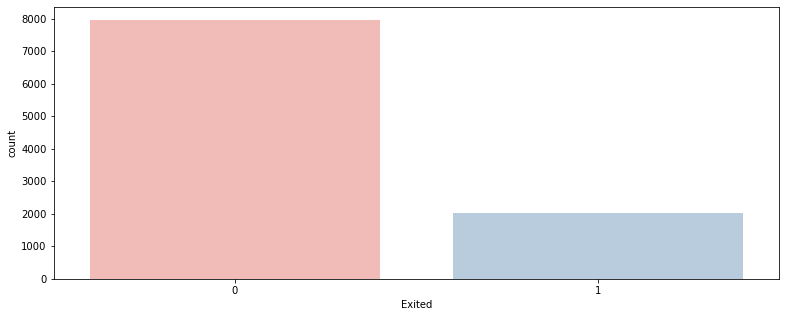

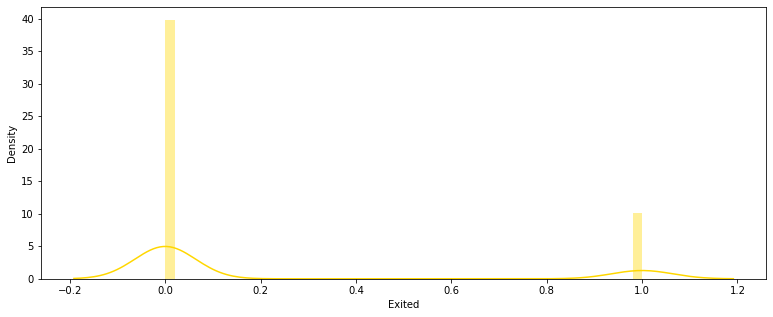

   Exited  count  percent
0       0   7963    79.63
1       1   2037    20.37

 Only 20.37% of our customers who got tendency to quit


In [25]:
plt.figure(figsize = (13, 5))
sns.countplot(df['Exited'], palette = 'Pastel1')
plt.show()
plt.figure(figsize = (13, 5))
sns.distplot(df['Exited'], color='gold')
plt.show()

print(df.stb.freq(['Exited'], cum_cols = False))
print('\n Only 20.37% of our customers who got tendency to quit')

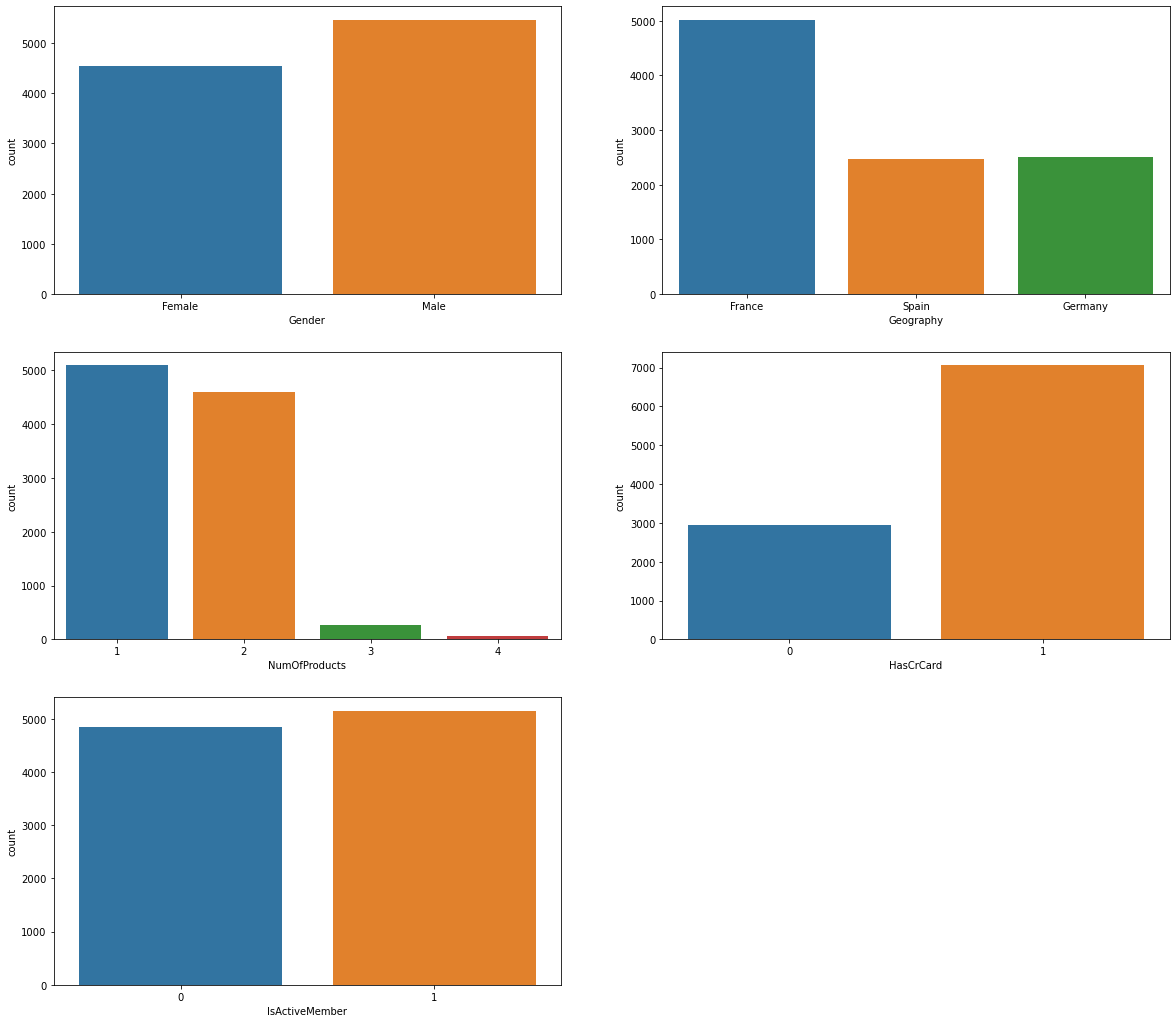

   Gender  count  percent
0    Male   5457    54.57
1  Female   4543    45.43

 Our male customers are slightly higher than our female customers with about 55%


  Geography  count  percent
0    France   5014    50.14
1   Germany   2509    25.09
2     Spain   2477    24.77

 Most of our customers are French.


   NumOfProducts  count  percent
0              1   5084    50.84
1              2   4590    45.90
2              3    266     2.66
3              4     60     0.60

 Most of our customers are having 1-2 product(s)


   HasCrCard  count  percent
0          1   7055    70.55
1          0   2945    29.45

 About 70% of our customers are having credit card.


   IsActiveMember  count  percent
0               1   5151    51.51
1               0   4849    48.49

 Half of our customers are note acive member.


In [26]:
plt.figure(figsize = (20, 18))

plt.subplot(3,2,1)
sns.countplot(df['Gender'])

plt.subplot(3,2,2)
sns.countplot(df['Geography'])

plt.subplot(3,2,3)
sns.countplot(df['NumOfProducts'])

plt.subplot(3,2,4)
sns.countplot(df['HasCrCard'])

plt.subplot(3,2,5)
sns.countplot(df['IsActiveMember'])

plt.show()

print(df.stb.freq(['Gender'], cum_cols = False))
print('\n Our male customers are slightly higher than our female customers with about 55%\n\n')

print(df.stb.freq(['Geography'], cum_cols = False))
print('\n Most of our customers are French.\n\n')

print(df.stb.freq(['NumOfProducts'], cum_cols = False))
print('\n Most of our customers are having 1-2 product(s)\n\n')

print(df.stb.freq(['HasCrCard'], cum_cols = False))
print('\n About 70% of our customers are having credit card.\n\n')

print(df.stb.freq(['IsActiveMember'], cum_cols = False))
print('\n Half of our customers are note acive member.')

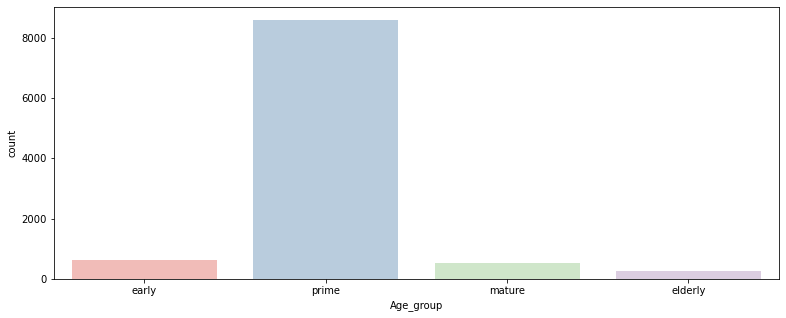

  Age_group  count  percent
0     prime   8589    85.89
1     early    611     6.11
2    mature    536     5.36
3   elderly    264     2.64

 Most of our customers are in Prime Working age


In [31]:
plt.figure(figsize = (13, 5))
sns.countplot(df['Age_group'], palette = 'Pastel1')
plt.show()

print(df.stb.freq(['Age_group'], cum_cols = False))
print('\n Most of our customers are in Prime Working age')

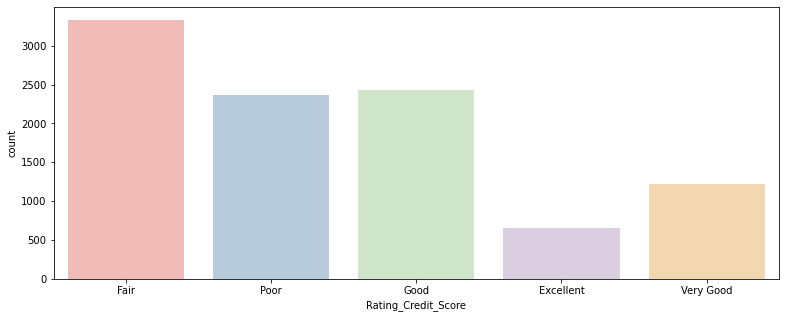

  Rating_Credit_Score  count  percent
0                Fair   3331    33.31
1                Good   2428    24.28
2                Poor   2362    23.62
3           Very Good   1224    12.24
4           Excellent    655     6.55

 Most of the customer are with Fair Ratings


In [38]:
plt.figure(figsize = (13, 5))
sns.countplot(df['Rating_Credit_Score'], palette = 'Pastel1')
plt.show()

print(df.stb.freq(['Rating_Credit_Score'], cum_cols = False))
print('\n Most of the customer are with Fair Ratings')

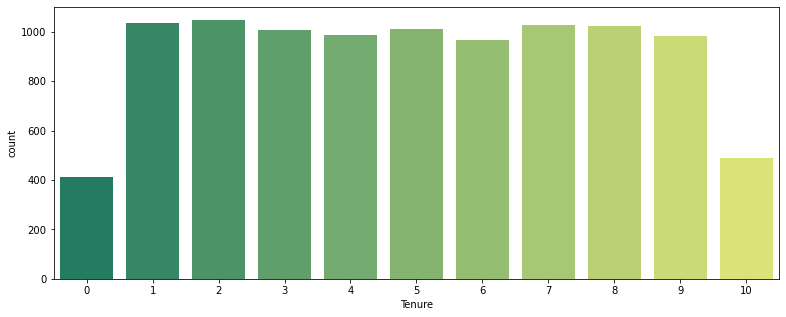

    Tenure  count  percent
0        2   1048    10.48
1        1   1035    10.35
2        7   1028    10.28
3        8   1025    10.25
4        5   1012    10.12
5        3   1009    10.09
6        4    989     9.89
7        9    984     9.84
8        6    967     9.67
9       10    490     4.90
10       0    413     4.13

 Most of our customers are having tenure between 1-9 years


In [43]:
plt.figure(figsize = (13, 5))
sns.countplot(df['Tenure'], palette = 'summer')
plt.show()

print(df.stb.freq(['Tenure'], cum_cols = False))
print('\n Most of our customers are having tenure between 1-9 years')

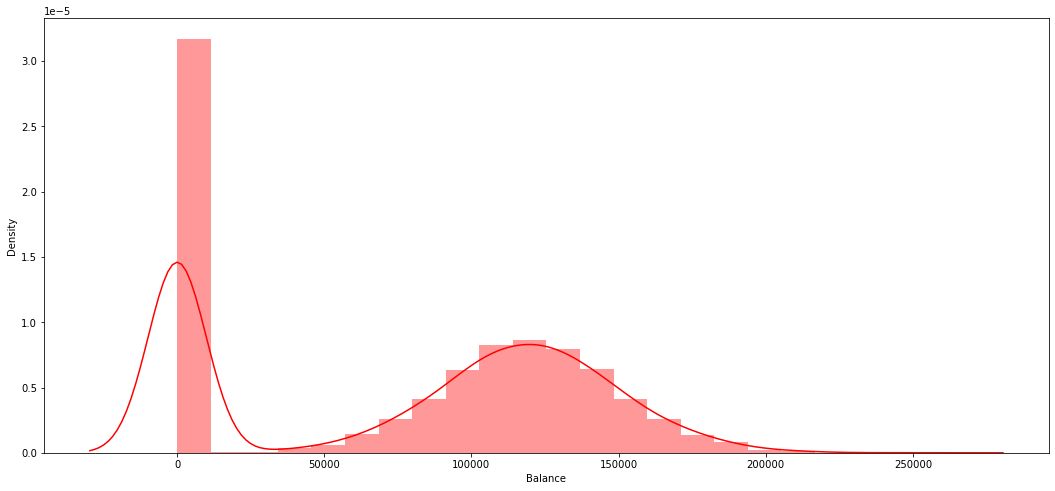

In [45]:
plt.figure(figsize = (18, 8))
sns.distplot(df['Balance'], color='red')
plt.show()

### Multivariate Analysis

### Gender and Exited

Exited    0    1
Gender          
Female 0.75 0.25
Male   0.84 0.16


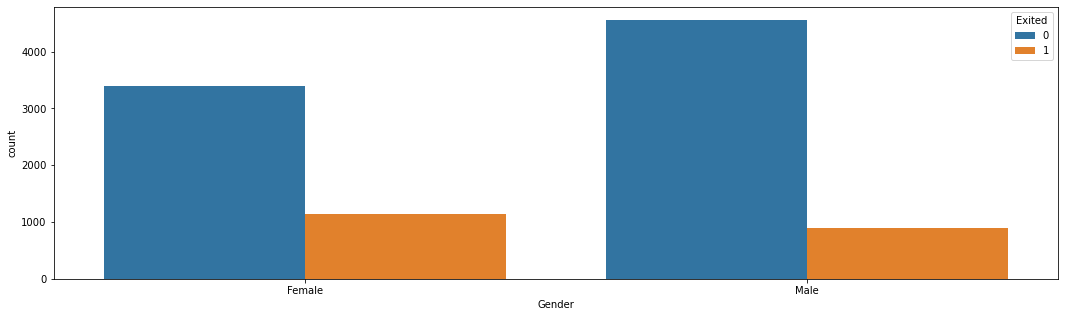

In [47]:
print(pd.crosstab(index = df['Gender'], columns = df['Exited'], normalize = 'index'))
plt.figure(figsize = (18, 5))
sns.countplot(df['Gender'], hue = df['Exited'])
plt.show()

#### Both female or male are mostly like to continue with our services.

### Average age and Exited

col_0   Age Mean
Exited          
0          37.41
1          44.84


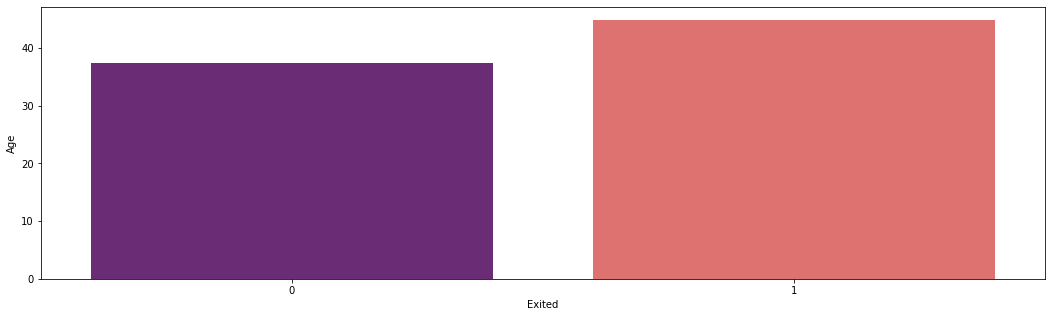

In [48]:
print(pd.crosstab(index = df['Exited'], columns = 'Age Mean', values = df['Age'], aggfunc='mean'))

plt.figure(figsize = (18, 5))
sns.barplot(x = df['Exited'], y = df['Age'], palette = 'magma', ci = False)
plt.show()

#### The average age of customer who is likely to churn is 45 years old, while for customers who is willing to stay is 37 years old. This shows that age doesn'r really have impacts on customer's decission to churn.

### Geography and Exited

Exited       0    1
Geography          
France    0.84 0.16
Germany   0.68 0.32
Spain     0.83 0.17


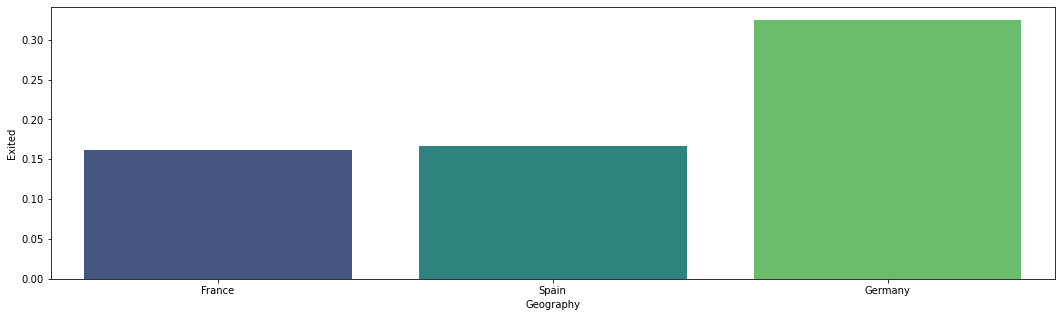

In [49]:
print(pd.crosstab(index = df['Geography'], columns = df['Exited'], normalize = 'index'))

plt.figure(figsize = (18, 5))
sns.barplot(x = df['Geography'], y = df['Exited'], palette = 'viridis', ci = False)
plt.show()

#### The tendency to churn is to see, that Germans are highest who probably churn with 32%.

### Age group and Exited

Exited       0    1
Age_group          
early     0.92 0.08
prime     0.80 0.20
mature    0.52 0.48
elderly   0.87 0.13


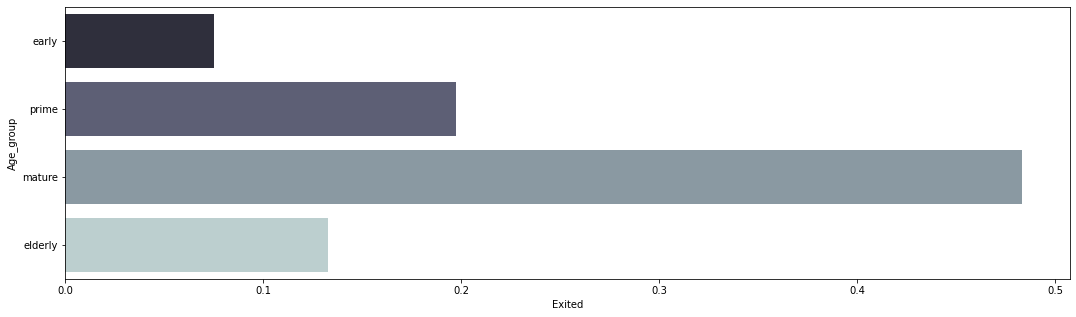

In [51]:
print(pd.crosstab(index = df['Age_group'], columns = df['Exited'], normalize = 'index'))

plt.figure(figsize = (18, 5))
sns.barplot(x = df['Exited'], y = df['Age_group'], palette = 'bone', ci = False)
plt.show()

#### The mature working age people are likely to churn with highest possibility (almost 50%), then come customers on prime working age.

### Credit Score Class and Exited

Rating_Credit_Score  Excellent  Fair  Good  Poor  Very Good
Exited                                                     
0                         0.80  0.79  0.81  0.78       0.79
1                         0.20  0.21  0.19  0.22       0.21


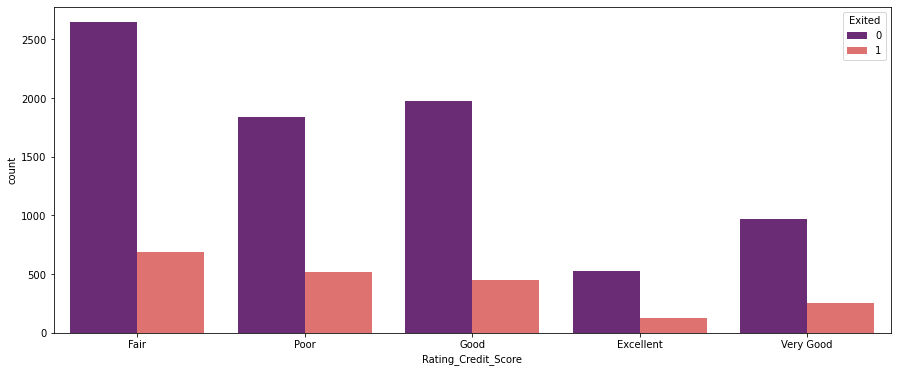

In [55]:
print(pd.crosstab(index = df['Exited'], columns = df['Rating_Credit_Score'], normalize = 'columns'))

plt.figure(figsize = (15, 6))
sns.countplot(df['Rating_Credit_Score'], hue = df['Exited'], palette='magma')
plt.show()

#### According to our credit Score rating, it is to see that most of our customers don't really have tendency tom churn.

### Customers with credit card and exited

HasCrCard    0    1
Exited             
0         0.29 0.71
1         0.30 0.70


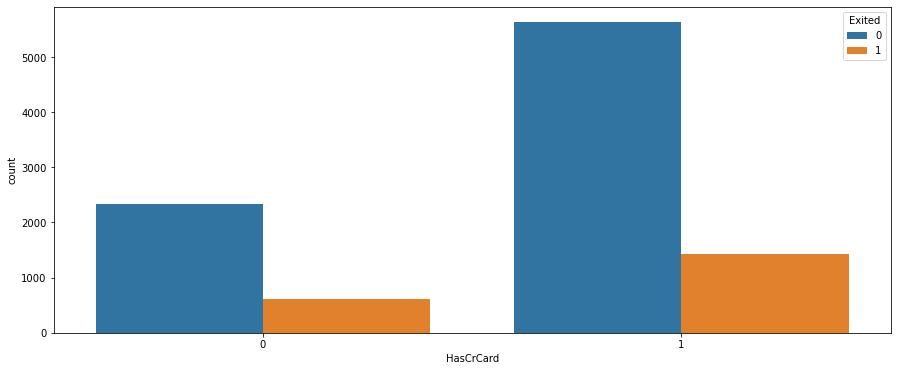

In [56]:
print(pd.crosstab(index = df['Exited'], columns = df['HasCrCard'], normalize = 'index'))

plt.figure(figsize = (15, 6))
sns.countplot(df['HasCrCard'], hue = df['Exited'])
plt.show()

#### It is to see, that most of our customers who have creditcards, have tendency to churn.

### Average Balance and exited

col_0   Average Balance
Exited                 
0              72745.30
1              91108.54


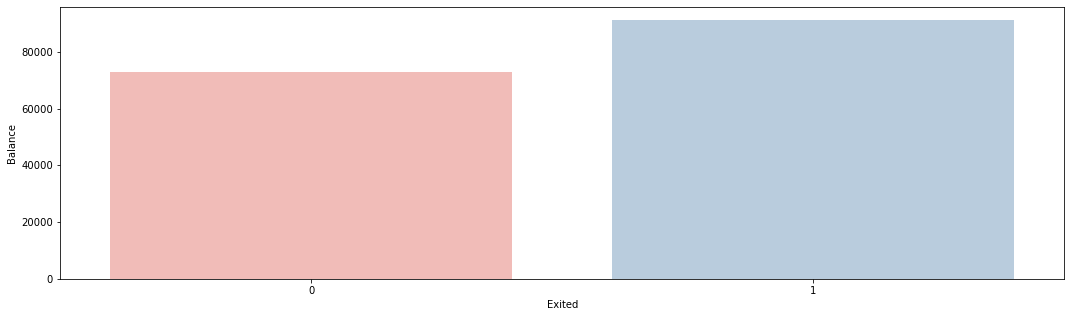

In [58]:
print(pd.crosstab(index = df['Exited'], columns = 'Average Balance', values = df['Balance'], aggfunc='mean'))

plt.figure(figsize = (18, 5))
sns.barplot(x = df['Exited'], y = df['Balance'], palette = 'Pastel1', ci = False)
plt.show()

#### The higher Average Balance ofour customers, that is more likely to churn.

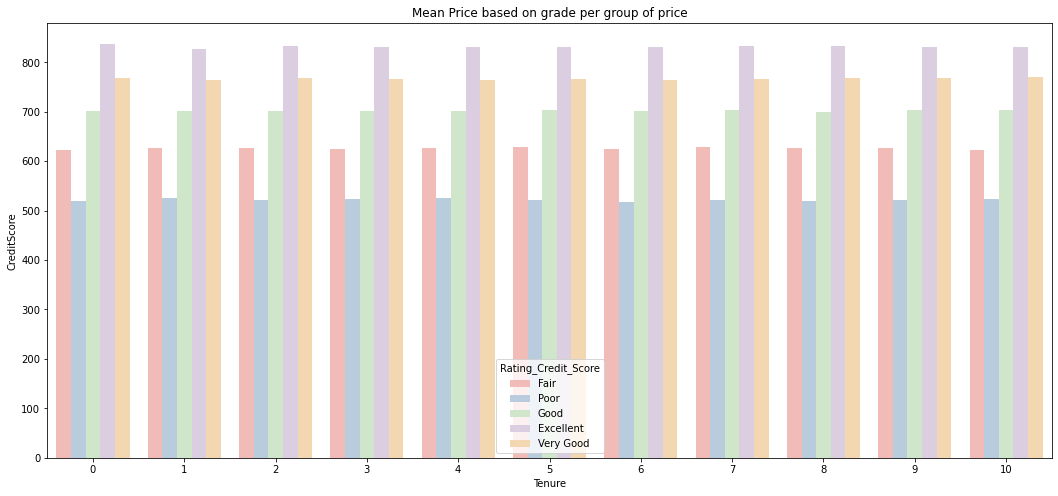

In [61]:
plt.figure(figsize = (18, 8))
sns.barplot(x = df['Tenure'], y = df['CreditScore'], hue = df['Rating_Credit_Score'], palette='Pastel1',ci = False)
plt.title('Mean Price based on grade per group of price')
plt.show()

#### On each tenure , it is more likely to see that our customers are on Excellent Rating

#### Higher Tenure = More Loyal

plt.figure(figsize = (13, 5))
sns.countplot('NumOfProducts', hue = 'Exited', data = df)
plt.show()
# Customer yang memiliki 2 produk memiliki rate untuk tetap paling tinggi
# Customer yang memiliki 4 produk memiliki rate untuk tetap paling rendah sebesar 0%

Exited           0    1
NumOfProducts          
1             0.72 0.28
2             0.92 0.08
3             0.17 0.83
4             0.00 1.00


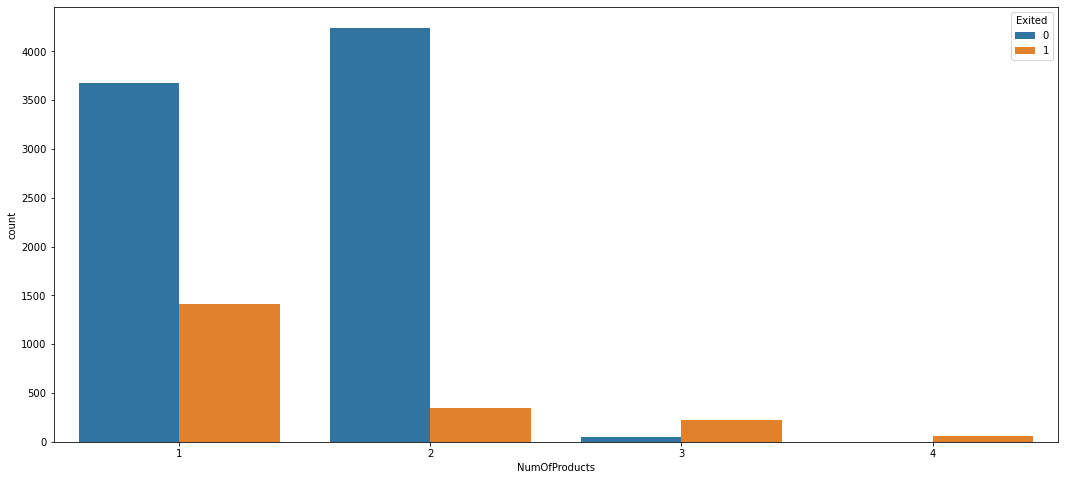

In [64]:
print(pd.crosstab(index = df['NumOfProducts'], columns = df['Exited'], normalize = 'index'))

plt.figure(figsize = (18, 8))
sns.countplot(x = df['NumOfProducts'], hue = df['Exited'])
plt.show()

#### Customer who have more than 2 products are morelikely to churn

## Summary

- We are already on right with keeping our customers to be loyal. 

- Only 20.37% of our customers who got tendency to quit

- Most of our customers are in prime Working age (25-54 years old)

- Most of our customers are french

- Our male customers are slightly higher than our female customers with about 55%
    - Female have tedency of Churn than Male

- Most of our customers are having 1-2 product(s)

- About 70% of our customers are having credit card.

- Half of our customers are not active member.



## Recommendation

- Before deciding Applications, there are several factors, we need to consider.

- Customer who had more than 2 products are morelikely to Churn
    - Do not offer Customer who have 2 products

- Improve Customer Service

- The Bank should give extra budget into marketing specifically for Female
    - Example: Giving Ticket for Holiday, Give Discount on Fashion, etc

- Do Customer Survey regarding the Bank

- Improve the Digital Section from the Bank
    - Such as: Online Banking, Mobile Banking, Internet Banking
- Pay attention more at the German, because they tend mostly to leave.
    - Perhaps we can do more special campaigns only for Germany.

- We should make more interesting and beneficial products targeting our 'Mature working age' class.
    - Programs made espescially for retirement

- Opening new branches near customer who have the Age group of 'Mature working age'.

- Having 24/7 Customer Service